# "Zindi South African COVID-19 Vulnerability Map "
>"South African COVID-19 Vulnerability Map by #ZindiWeekendz
https://zindi.africa/hackathons/south-african-covid-19-vulnerability-map"


In [0]:
import numpy as np
import os
import glob
import pandas as pd
from google.colab import drive
import cv2
from pathlib import Path
import xgboost as xgb

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data=pd.read_csv('/content/drive/My Drive/Zindi_Hack/Train_maskedv2.csv')
print('The dimensions of training data is:',data.shape)
print('------------------------------------------------')
print(data.head(5))

The dimensions of training data is: (3174, 50)
------------------------------------------------
      ward  total_households  total_individuals  ...     pg_03     pg_04    lgt_00
0  9D9BEUB       13569.97801        39024.03083  ...  0.029031  0.010292  0.599259
1  RERH3XM       13593.88256        32879.94646  ...  0.000586  0.002832  0.699136
2  GJWA3BO        2698.30050         8261.71093  ...  0.003201  0.000663  0.972315
3  GW6VRB7        1965.96698         9069.77694  ...  0.054701  0.002299  0.735333
4  CN9JZJC        1852.07821         9908.84404  ...  0.000704  0.000714  0.646964

[5 rows x 50 columns]


In [0]:
#Let us try and find out the missing values in the train data
data.isna().sum() 
# Looks like no missing data

ward                    0
total_households        0
total_individuals       0
target_pct_vunerable    0
dw_00                   0
dw_01                   0
dw_02                   0
dw_03                   0
dw_04                   0
dw_05                   0
dw_06                   0
dw_07                   0
dw_08                   0
dw_09                   0
dw_10                   0
dw_11                   0
dw_12                   0
dw_13                   0
psa_00                  0
psa_01                  0
psa_02                  0
psa_03                  0
psa_04                  0
stv_00                  0
stv_01                  0
car_00                  0
car_01                  0
lln_00                  0
lln_01                  0
lan_00                  0
lan_01                  0
lan_02                  0
lan_03                  0
lan_04                  0
lan_05                  0
lan_06                  0
lan_07                  0
lan_08                  0
lan_09      

In [0]:
# Let us try and find out if there any non-numeric data in the training data
non_numeric=[cols for cols in data.columns if data[cols].dtypes=='object']
non_numeric
# Obviously ward is an alpha numeric value used for uniquely determining the locality

['ward']

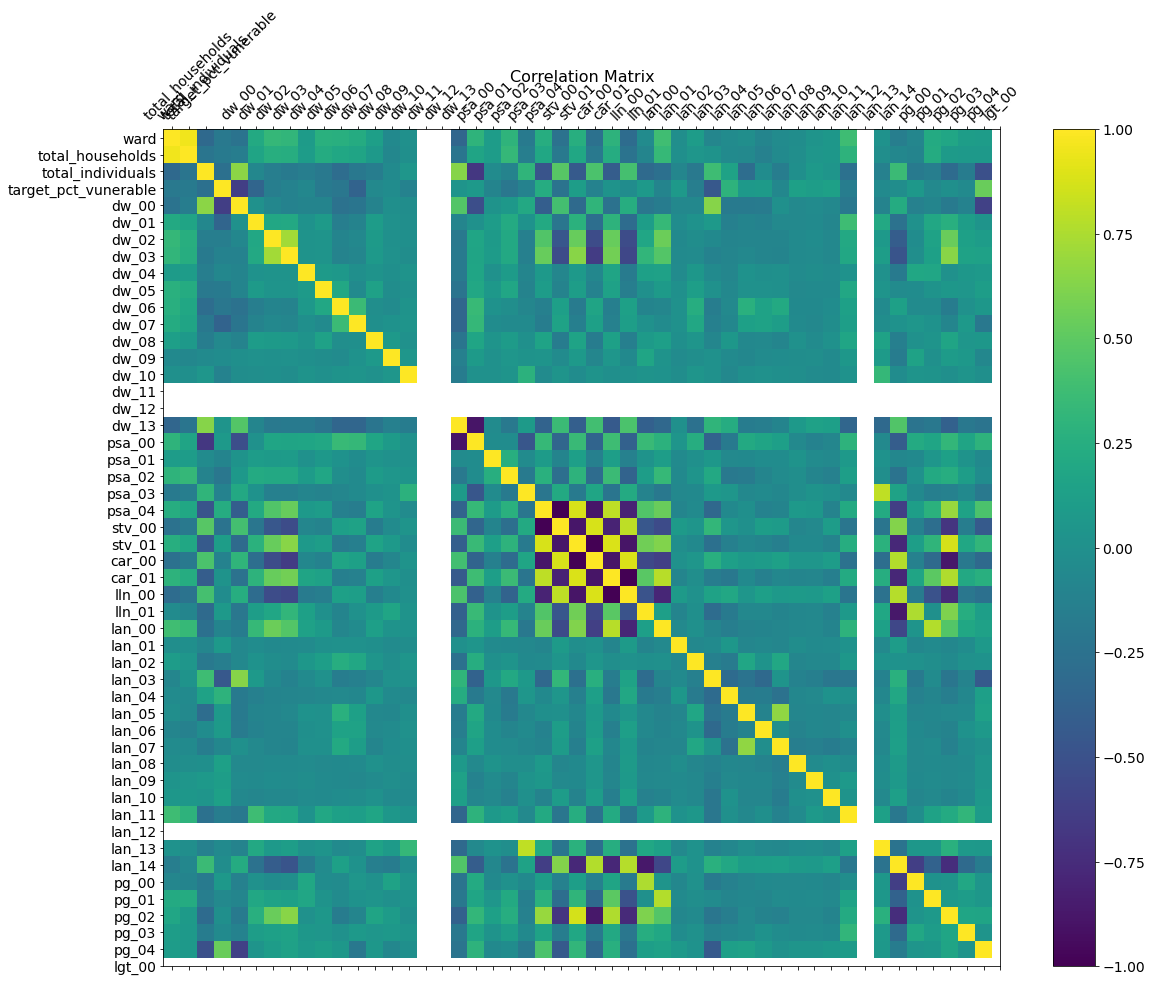

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [0]:
data.columns

Index(['ward', 'total_households', 'total_individuals', 'target_pct_vunerable',
       'dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'dw_12', 'dw_13', 'psa_00',
       'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00',
       'car_01', 'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03',
       'lan_04', 'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10',
       'lan_11', 'lan_12', 'lan_13', 'lan_14', 'pg_00', 'pg_01', 'pg_02',
       'pg_03', 'pg_04', 'lgt_00'],
      dtype='object')

In [0]:
#Lets split the data
from sklearn.model_selection import train_test_split
train_cols= ['total_households', 'total_individuals', 
       'dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'dw_12', 'dw_13', 'psa_00',
       'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00',
       'car_01', 'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03',
       'lan_04', 'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10',
       'lan_11', 'lan_12', 'lan_13', 'lan_14', 'pg_00', 'pg_01', 'pg_02',
       'pg_03', 'pg_04', 'lgt_00']
target_cols=['target_pct_vunerable']
X=data[train_cols]
y=data[target_cols]
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.50,random_state = 123)
print('The training data dimensions are:',train_X.shape,'------',train_y.shape)
print('The validation data dimensions are:',val_X.shape,'------',val_y.shape)

The training data dimensions are: (1587, 48) ------ (1587, 1)
The validation data dimensions are: (1587, 48) ------ (1587, 1)


In [0]:
#Lets try a simple random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
forest_model = RandomForestRegressor(random_state=123)
forest_model.fit(train_X, train_y)
preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, preds))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


3.8639445471437255


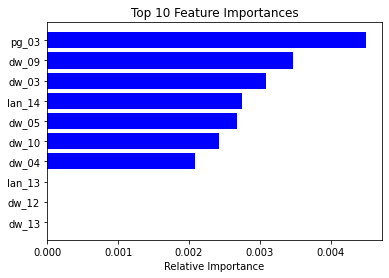

In [0]:
#Lets see the variable importance
importances = forest_model.feature_importances_
indices = np.argsort(importances)[:10]
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [train_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
#Lets try and find out the cross-validation accuracy of a random forest model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_model, X, y, cv=5,scoring='neg_mean_absolute_error')
print("Mean absolute error : %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Mean absolute error : 3.93 (+/- 0.26)


In [0]:
#Now lets try xgboost
import xgboost as xgb
xgb_reg=xgb.XGBRegressor(random_state=123)
xgb_reg.fit(train_X,train_y)
#print('Now cross validating')
#print('-------------------------------')
#xgb_scores = cross_val_score(xgb_reg, X, y, cv=5,scoring='neg_mean_absolute_error')
#print("Mean absolute error : %0.2f (+/- %0.2f)" % (-xgb_scores.mean(), xgb_scores.std() * 2))

[19:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
preds = xgb_reg.predict(val_X)
print(mean_absolute_error(val_y, preds))

4.045821563802859


In [0]:
X['new']=xgb_reg.predict(X)
X.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(3174, 49)

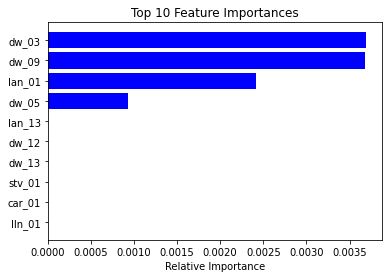

In [0]:
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[:10]
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [train_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
!pip install catboost

     |████████████████████████████████| 64.4MB 61kB/s 


In [0]:
#Now lets try CatBoost
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
catboost_scores=0.0
fold = 0
catboost_reg=CatBoostRegressor(random_state=123)
for train_index, test_index in kf.split(X):
  print('In fold',fold+1)
  X_train, X_test = X.iloc[train_index][:], X.iloc[test_index][:]
  y_train, y_test = y.iloc[train_index][:], y.iloc[test_index][:]
  catboost_reg.fit(X_train,y_train,use_best_model=True,eval_set=(X_test,y_test),plot=True,early_stopping_rounds=3)
  catboost_scores=catboost_scores+mean_absolute_error(y_test,catboost_reg.predict(X_test))
  fold = fold + 1
print('The cross validation MAE:',catboost_scores/5)

In [0]:
grid = {'learning_rate': [0.01,0.03, 0.1],
        'depth': [4, 6, 15],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
randomized_search_result = catboost_reg.randomized_search(grid,
                                                   X=X,
                                                   y=y,
                                                   cv=5
                                                   )

In [0]:
print('Now cross validating')
print('-------------------------------')
catboost_scores = cross_val_score(catboost_reg, X, y, cv=5,scoring='neg_mean_absolute_error')
print("Mean absolute error : %0.2f (+/- %0.2f)" % (-catboost_scores.mean(), catboost_scores.std() * 2))

Streaming output truncated to the last 5000 lines.
6:	learn: 10.2536343	total: 97.2ms	remaining: 13.8s
7:	learn: 9.9715927	total: 110ms	remaining: 13.7s
8:	learn: 9.7014336	total: 125ms	remaining: 13.8s
9:	learn: 9.4380991	total: 138ms	remaining: 13.7s
10:	learn: 9.1846751	total: 151ms	remaining: 13.5s
11:	learn: 8.9387565	total: 167ms	remaining: 13.7s
12:	learn: 8.7106519	total: 181ms	remaining: 13.7s
13:	learn: 8.5196573	total: 194ms	remaining: 13.6s
14:	learn: 8.3107722	total: 206ms	remaining: 13.6s
15:	learn: 8.1138971	total: 219ms	remaining: 13.5s
16:	learn: 7.9277338	total: 232ms	remaining: 13.4s
17:	learn: 7.7601372	total: 244ms	remaining: 13.3s
18:	learn: 7.5939878	total: 257ms	remaining: 13.2s
19:	learn: 7.4412649	total: 270ms	remaining: 13.2s
20:	learn: 7.3090708	total: 282ms	remaining: 13.2s
21:	learn: 7.1833926	total: 295ms	remaining: 13.1s
22:	learn: 7.0568433	total: 308ms	remaining: 13.1s
23:	learn: 6.9369483	total: 322ms	remaining: 13.1s
24:	learn: 6.8269784	total: 335ms

In [0]:
#Lets try a LightGBM model
import lightgbm as lgbm
lgbm_reg=lgbm.LGBMRegressor(random_state=123)
kf = KFold(n_splits=5)
lgbm_scores=0.0
fold = 0
for train_index, test_index in kf.split(X):
  print('In fold',fold+1)
  X_train, X_test = X.iloc[train_index][:], X.iloc[test_index][:]
  y_train, y_test = y.iloc[train_index][:], y.iloc[test_index][:]
  lgbm_reg.fit(X_train,y_train,eval_set=(X_test,y_test),early_stopping_rounds=3,metric=)
  lgbm_scores=lgbm_scores+mean_absolute_error(y_test,lgbm_reg.predict(X_test))
  fold = fold + 1
print('The cross validation MAE:',lgbm_scores/5)

In [0]:
test=pd.read_csv('/content/drive/My Drive/Zindi_Hack/Test_maskedv2.csv')
print('The dimension of test data:',test.shape)

The dimension of test data: (1102, 49)


In [0]:
test.head()

,ward,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00
0,00A93O0,2514.04172,8037.06199,0.671962,0.061074,0.101516,0.006891,0.021287,0.015615,0.035974,0.010995,0.030665,0.000563,0.004513,0.038943,0,0,0.327785,0.400204,0.000142,0.090634,0.181234,0.082473,0.917527,0.170320,0.829680,0.028193,0.971807,0.006861,0.025960,0.001401,0.864523,0.010393,0.001966,0.004094,0.000991,0.007919,0.000136,0.000146,0.000420,0.011485,0,0.063705,0.979272,0.009926,0.003224,0.002697,0.004882,0.521007
1,01V40KO,1829.71944,7494.86917,0.542857,0.390850,0.039623,0.000000,0.000000,0.000000,0.002633,0.005074,0.010439,0.000000,0.000544,0.007980,0,0,0.396451,0.448673,0.002026,0.015543,0.137307,0.028539,0.971461,0.087096,0.912904,0.014139,0.985861,0.003348,0.008866,0.001654,0.968007,0.005108,0.002472,0.001524,0.001974,0.006575,0.000152,0.000160,0.000000,0.000160,0,0.000000,0.998938,0.000296,0.000301,0.000305,0.000160,0.693716
2,01ZHVW0,1721.99009,5847.43254,0.968071,0.003525,0.001431,0.000000,0.000000,0.000000,0.018546,0.004769,0.000825,0.000000,0.000000,0.002832,0,0,0.315332,0.550687,0.000000,0.009654,0.124326,0.108260,0.891740,0.115144,0.884856,0.047064,0.952936,0.037169,0.019334,0.001471,0.918999,0.003145,0.001087,0.001963,0.001543,0.005908,0.000000,0.002075,0.000631,0.006504,0,0.000171,0.955895,0.012170,0.000000,0.030012,0.001923,0.933954
3,028YQJX,12388.02257,52211.66859,0.397274,0.004734,0.001068,0.000279,0.000799,0.197760,0.005227,0.065487,0.316633,0.003892,0.000279,0.006569,0,0,0.242343,0.568208,0.001050,0.066225,0.122174,0.146214,0.853786,0.223657,0.776343,0.174330,0.825670,0.485175,0.240164,0.002869,0.242053,0.003676,0.000726,0.008142,0.003545,0.003591,0.000629,0.000505,0.000593,0.008330,0,0.000000,0.293629,0.694779,0.003238,0.000628,0.007726,0.921470
4,02G8W11,1754.25716,4266.57609,0.815197,0.016697,0.078571,0.008975,0.047882,0.015398,0.007264,0.000000,0.000712,0.007003,0.000877,0.001425,0,0,0.110625,0.663775,0.000000,0.024673,0.200927,0.723028,0.276972,0.930886,0.069114,0.808671,0.191329,0.457734,0.334764,0.000843,0.005681,0.001384,0.000000,0.002514,0.000829,0.000284,0.000290,0.000000,0.000234,0.016846,0,0.178598,0.110861,0.054114,0.006062,0.823495,0.005470,0.996227


In [0]:
test['new']=xgb_reg.predict(test[train_cols])
test.shape

(1102, 50)

In [0]:
sample=pd.read_csv('/content/drive/My Drive/Zindi_Hack/samplesubmissionv2.csv')
sample.head()

,ward,target_pct_vunerable
0,00A93O0,NaN
1,01V40KO,NaN
2,01ZHVW0,NaN
3,028YQJX,NaN
4,02G8W11,NaN


In [0]:
sample['target_pct_vunerable']=(catboost_reg.predict(test[train_cols+['new']]))
sample.shape

(1102, 2)

In [0]:
sample.head()

,ward,target_pct_vunerable
0,00A93O0,17.669271
1,01V40KO,35.082365
2,01ZHVW0,1.799878
3,028YQJX,2.715354
4,02G8W11,0.772809


In [0]:
sample.to_csv('/content/drive/My Drive/Zindi_Hack/submission_stack.csv',index=False)